In [5]:
%%capture
# Install relevant libraries
!pip install geopandas folium 
!pip install pandas numpy geopandas folium matplotlib seaborn scikit-learn tqdm

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [7]:
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [11]:
DATA_PATH = '../playground-series-s3e20'
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51000,29.29000,2019,0,-0.00011,0.60302,-0.00007,0.25567,-98.59389,...,3664.43622,61085.80957,2615.12048,15.56853,0.27229,-12.62899,35.63242,-138.78642,30.75214,3.75099
1,ID_-0.510_29.290_2019_01,-0.51000,29.29000,2019,1,0.00002,0.72821,0.00001,0.13099,16.59286,...,3651.19031,66969.47873,3174.57242,8.69060,0.25683,30.35938,39.55763,-145.18393,27.25178,4.02518
2,ID_-0.510_29.290_2019_02,-0.51000,29.29000,2019,2,0.00051,0.74820,0.00038,0.11002,72.79584,...,4216.98649,60068.89445,3516.28267,21.10341,0.25110,15.37788,30.40182,-142.51954,26.19330,4.23138
3,ID_-0.510_29.290_2019_03,-0.51000,29.29000,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.50774,51064.54734,4180.97332,15.38690,0.26204,-11.29340,24.38036,-132.66583,28.82915,4.30529
4,ID_-0.510_29.290_2019_04,-0.51000,29.29000,2019,4,-0.00008,0.67630,-0.00005,0.12116,4.12127,...,3980.59812,63751.12578,3355.71011,8.11469,0.23585,38.53226,37.39298,-141.50981,22.20461,4.34732


In [12]:
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51000,29.29000,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.02734,8472.31348,41047.93750,7472.31348,7.93562,0.24077,-100.11379,33.69704,-133.04755,33.77958
1,ID_-0.510_29.290_2022_01,-0.51000,29.29000,2022,1,0.00046,0.69116,0.00032,0.00000,76.23920,...,48539.73724,6476.14732,54915.70858,5476.14716,11.44844,0.29312,-30.51032,42.40259,-138.63282,31.01238
2,ID_-0.510_29.290_2022_02,-0.51000,29.29000,2022,2,0.00016,0.60511,0.00011,0.07987,-42.05534,...,34133.08047,8984.79570,39006.09375,7984.79570,10.75318,0.26713,39.08736,45.93648,-144.78499,26.74336
3,ID_-0.510_29.290_2022_03,-0.51000,29.29000,2022,3,0.00035,0.69692,0.00024,0.20103,72.16957,...,50854.99108,6014.72406,57646.36837,5014.72412,11.76456,0.30468,-24.46513,42.14042,-135.02789,29.60477
4,ID_-0.510_29.290_2022_04,-0.51000,29.29000,2022,4,-0.00032,0.58053,-0.00018,0.20435,76.19086,...,46594.68514,6849.28048,52896.54187,5849.28039,13.06532,0.28422,-12.90785,30.12264,-135.50012,26.27681


In [14]:
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94000
1,ID_-0.510_29.290_2022_01,81.94000
2,ID_-0.510_29.290_2022_02,81.94000
3,ID_-0.510_29.290_2022_03,81.94000
4,ID_-0.510_29.290_2022_04,81.94000
5,ID_-0.510_29.290_2022_05,81.94000
6,ID_-0.510_29.290_2022_06,81.94000
7,ID_-0.510_29.290_2022_07,81.94000
8,ID_-0.510_29.290_2022_08,81.94000
9,ID_-0.510_29.290_2022_09,81.94000


In [15]:
train.shape, test.shape, samplesubmission.shape

((79023, 76), (24353, 75), (24353, 2))

In [16]:
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.23557692307692307

Statistical summaries

In [17]:
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023,79023.00000,79023.00000,79023.00000,79023.00000,64414.00000,64414.00000,64414.00000,64414.00000,64414.00000,...,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,78539.00000,79023.00000
unique,79023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-0.510_29.290_2019_00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-1.89107,29.88015,2020.00000,26.00000,0.00005,0.83485,0.00004,0.15842,-7.92587,...,5592.37748,59420.29746,4670.43087,19.13924,0.27146,-10.78483,40.43698,-86.80058,27.92598,81.94055
std,NaN,0.69452,0.81038,0.81650,15.29716,0.00027,0.18538,0.00021,0.07136,64.26337,...,1428.50300,9051.16361,1359.25158,13.54705,0.04943,30.37446,6.42822,37.83727,4.40384,144.29965
min,NaN,-3.29900,28.22800,2019.00000,0.00000,-0.00100,0.24182,-0.00089,0.00000,-179.53706,...,1050.66178,24779.03370,1050.49682,1.84453,0.01770,-102.73973,2.99887,-153.46421,10.81829,0.00000
25%,NaN,-2.45100,29.26200,2019.00000,13.00000,-0.00010,0.70582,-0.00008,0.11053,-56.78238,...,4595.40052,53175.77993,3680.85634,9.97457,0.24145,-30.30917,35.82991,-125.99116,24.68676,9.79800
50%,NaN,-1.88200,29.88300,2020.00000,26.00000,0.00002,0.80912,0.00002,0.16185,-12.44173,...,5573.85431,59332.53255,4621.75517,15.13069,0.27275,-12.67391,41.11963,-84.64435,28.33363,45.59345
75%,NaN,-1.30300,30.47100,2021.00000,39.00000,0.00015,0.94279,0.00012,0.21182,72.05999,...,6542.30364,65663.84268,5572.98322,23.78503,0.30289,9.40220,44.44627,-48.13270,31.49988,109.54959


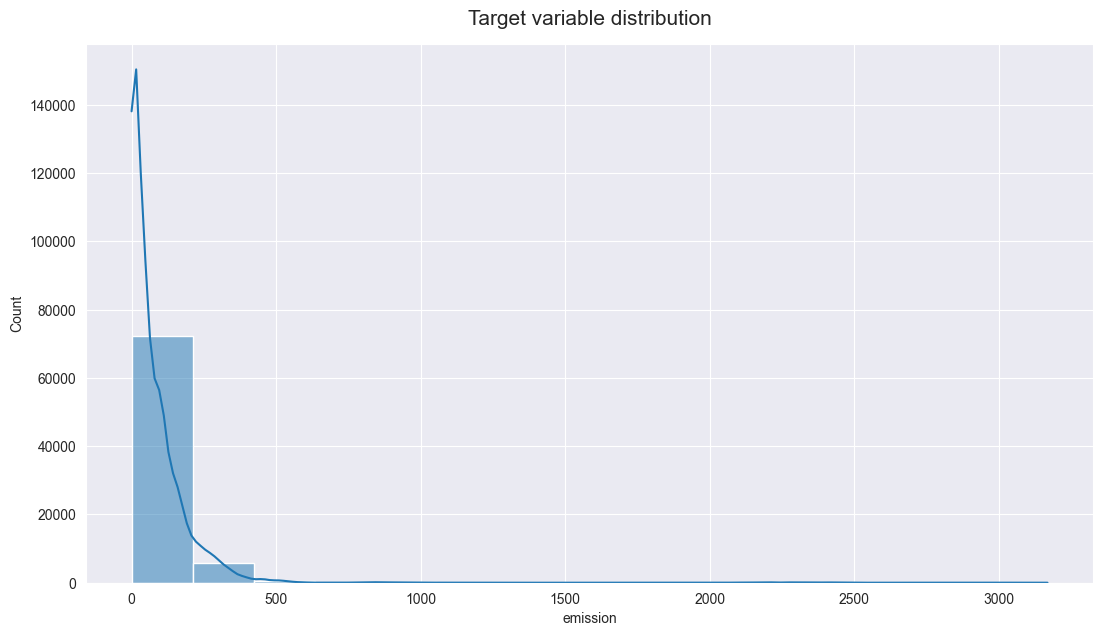

None

10.173825825101622

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

Outliares

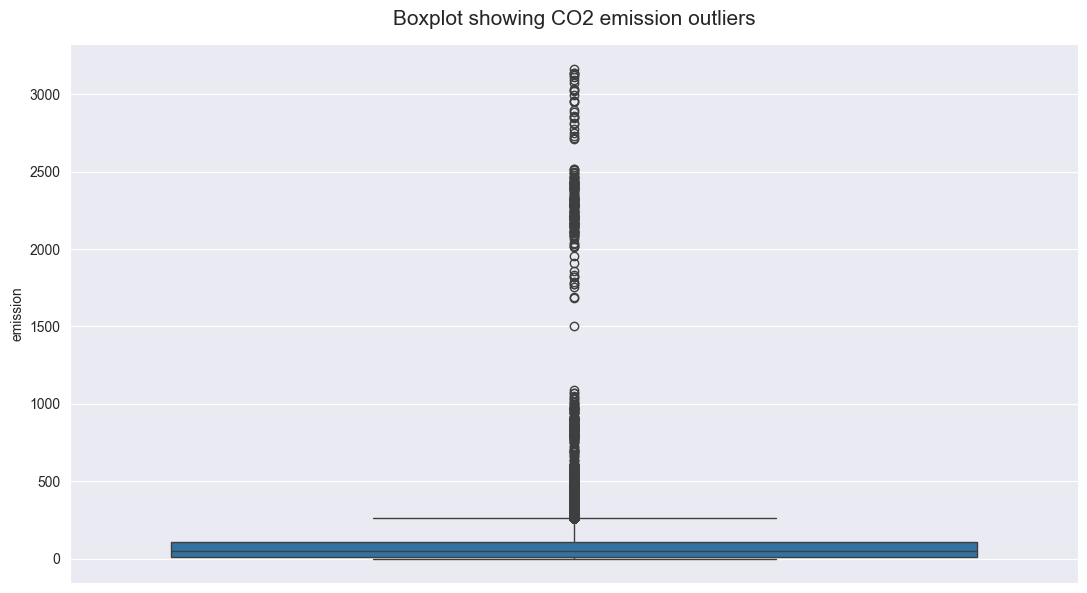

In [21]:
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

In [22]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-0.51000,29.29000,train,POINT (29.29000 -0.51000)
1,-0.52800,29.47200,train,POINT (29.47200 -0.52800)
2,-0.54700,29.65300,train,POINT (29.65300 -0.54700)
3,-0.56900,30.03100,train,POINT (30.03100 -0.56900)
4,-0.59800,29.10200,train,POINT (29.10200 -0.59800)


In [25]:
type(geo_df.geometry)

geopandas.geoseries.GeoSeries

In [24]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

In [26]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

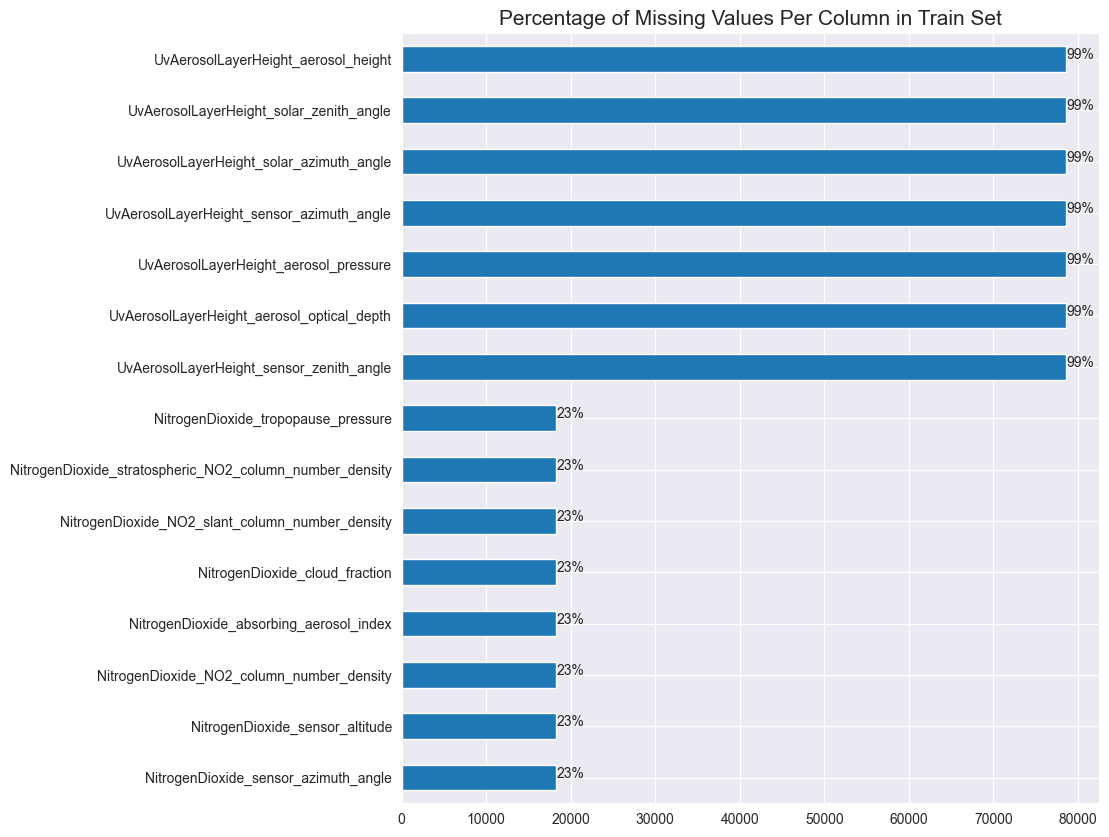

In [27]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [28]:
train.duplicated().any(), test.duplicated().any()

(False, False)

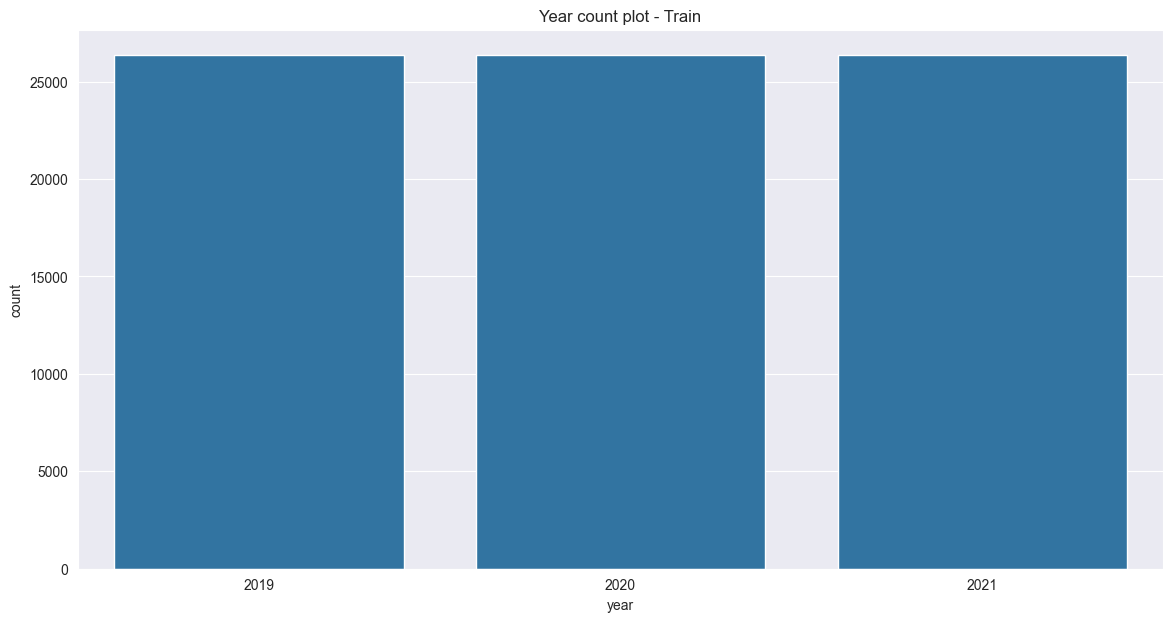

In [29]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot - Train')
plt.show()

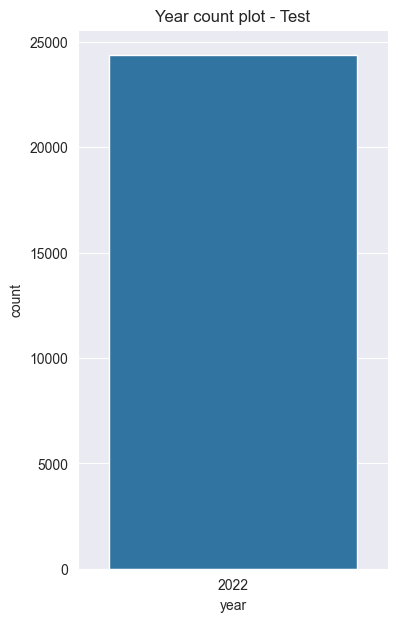

In [30]:
# Year countplot
plt.figure(figsize = (4, 7))
sns.countplot(x = 'year', data = test)
plt.title('Year count plot - Test')
plt.show()

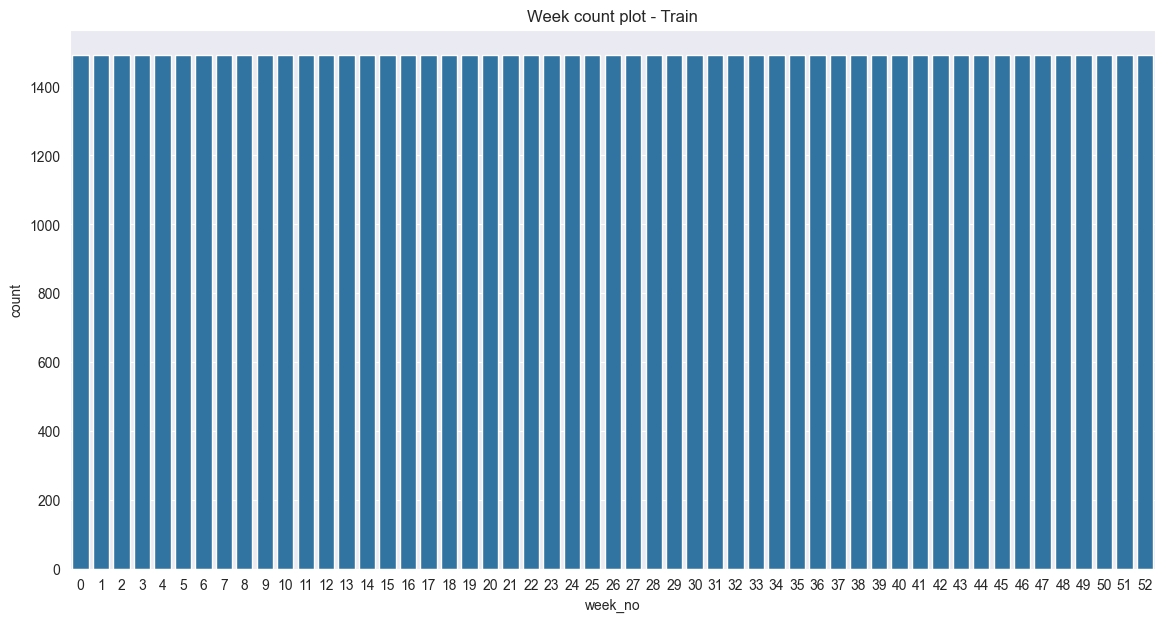

In [31]:
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot - Train')
plt.show()

In [34]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,53
2020,53
2021,53


In [35]:
# Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                   1.00000
longitude                                                  0.10275
UvAerosolLayerHeight_aerosol_height                        0.06901
UvAerosolLayerHeight_aerosol_pressure                      0.06814
Cloud_surface_albedo                                       0.04659
CarbonMonoxide_H2O_column_number_density                   0.04322
CarbonMonoxide_CO_column_number_density                    0.04133
Formaldehyde_tropospheric_HCHO_column_number_density_amf   0.04026
UvAerosolLayerHeight_aerosol_optical_depth                 0.04016
UvAerosolLayerHeight_sensor_azimuth_angle                  0.03514
NitrogenDioxide_solar_azimuth_angle                        0.03342
Formaldehyde_tropospheric_HCHO_column_number_density       0.03333
SulphurDioxide_solar_azimuth_angle                         0.03234
Formaldehyde_solar_azimuth_angle                           0.03081
NitrogenDioxide_sensor_altitude                            0.0

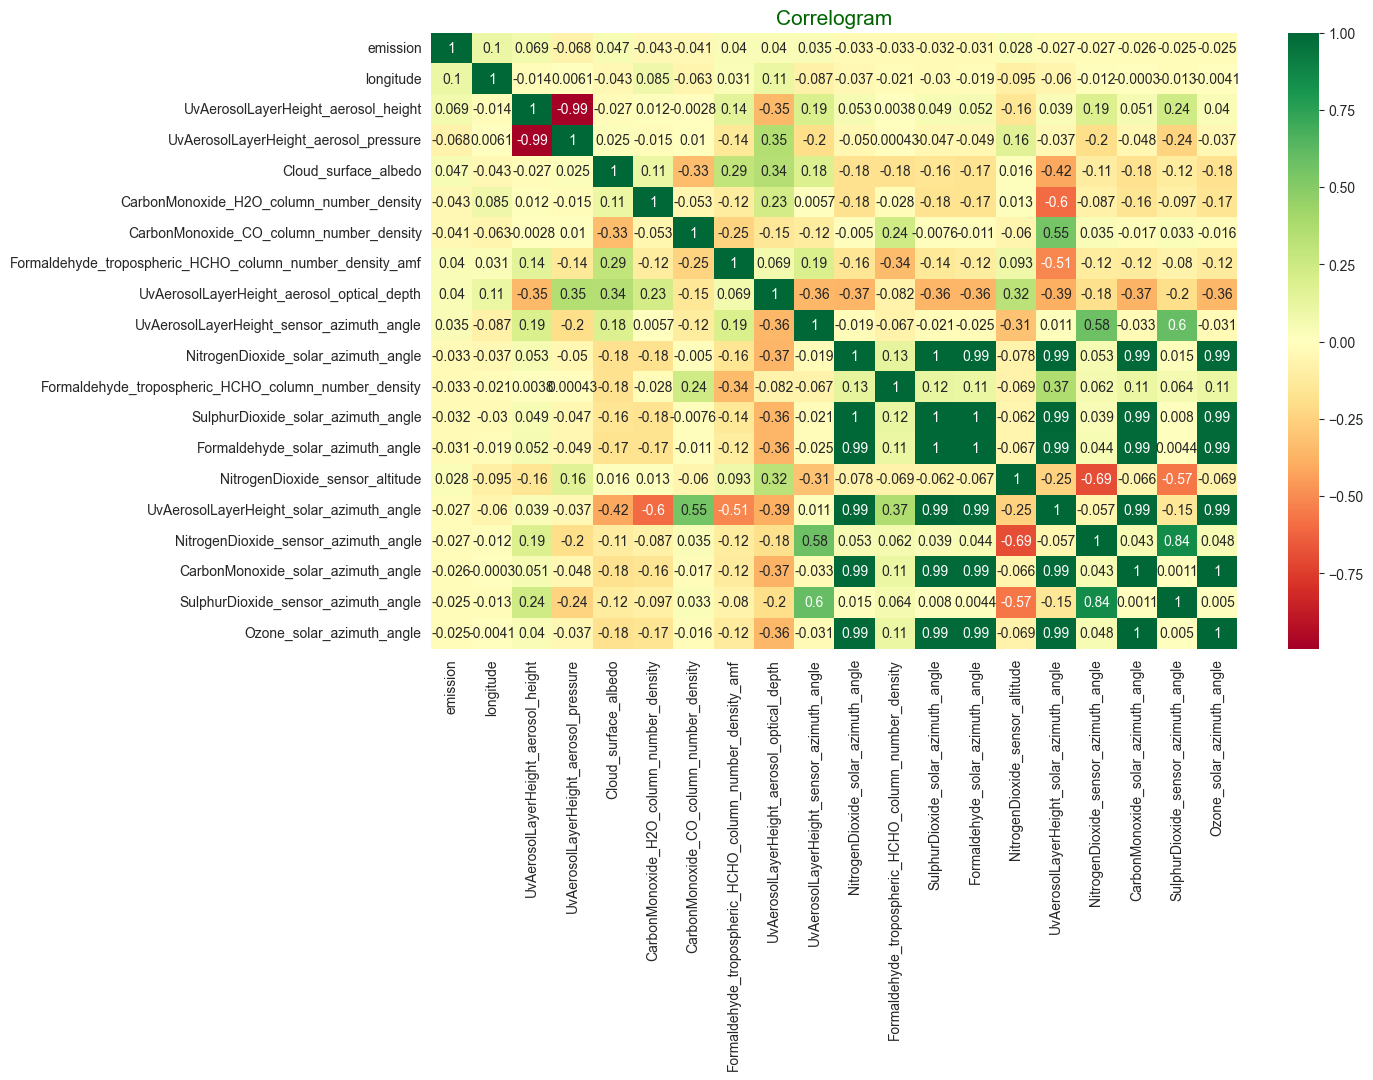

In [36]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

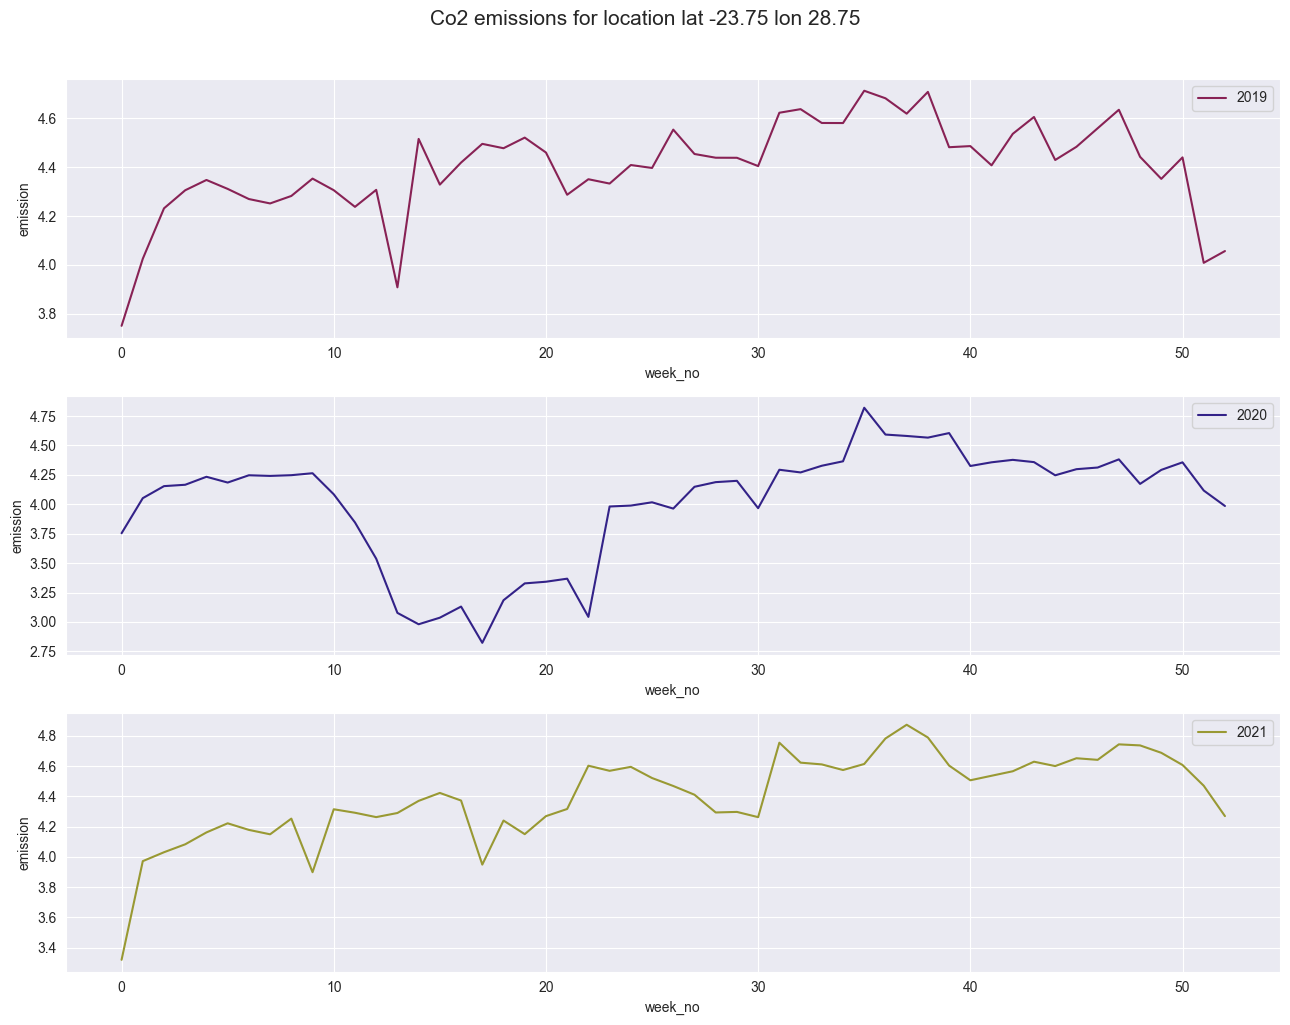

In [37]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -0.510) & (train.longitude == 29.290)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(x=df.week_no,y= df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()